# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable, if you will) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from math import ceil

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions.

In [2]:
# Reading data.
model_data = pd.read_csv("footballer_data.csv")

# Dropping unnecessary columns, getting dummy variables.
model_data = model_data.drop(columns = ["ID", "club", "club_logo", "birth_date", "flag", "nationality", "photo", "potential"])
model_data = pd.get_dummies(model_data, drop_first=True)

# Displaying cleaned data.
model_data

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,0,0,1,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,1,0,1,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,0,0,0,1,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,0,0,0,1,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17989,17,188.0,74.0,46,46,47,49,48,28,42,1,1,2,14,5,10,19,6,12,13,12,21,12,24,32,38,40,26,19,31,28,50,7,16,9,6,26,17,23,9,11,0,1,0,1,1
17990,47,185.0,77.0,46,39,50,39,37,25,50,1,1,2,11,11,12,12,12,11,12,11,13,22,25,25,35,51,44,13,51,32,47,16,44,16,13,17,22,44,14,12,0,1,0,1,1
17991,17,175.0,71.0,46,58,47,35,43,20,33,1,2,2,28,47,47,42,33,37,32,25,30,41,66,51,60,54,77,42,73,33,32,51,26,16,46,37,58,50,18,17,0,1,0,1,0
17992,18,176.0,61.0,46,58,35,44,45,45,47,1,2,2,34,32,40,49,25,41,30,34,44,43,57,58,58,49,74,43,56,49,46,32,46,46,37,51,43,45,43,48,0,1,0,1,1


### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors resulting if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the errors and print their mean and standard deviation.

Mean: 5.491330443481161, stdev: 4.261886186448831


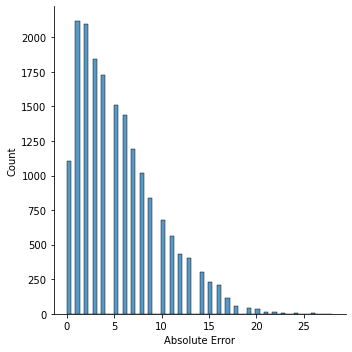

In [3]:
# Define mean absolute error function  
def absolute_error(y_hat, y):
    return abs(y_hat-y)

def mean_absolute_error(y_hat, y):
    return np.mean(abs(y_hat-y))
    
# Retrieving y data.
y= model_data.overall

# Creating prediction array of just the median for the baseline.
median = np.median(model_data.overall)
y_hat = np.repeat(median, len(y))

# Getting MAE, and standard deviation of the errors.
errors = absolute_error(y_hat, y)
mae = mean_absolute_error(y_hat, y)
stdev = np.std(errors)

# Printing mean and standard deviation of errors.
print("Mean: {}, stdev: {}".format(mae, stdev))


# Plot distribution  
sns.displot(errors).set(xlabel="Absolute Error")



### Question 2: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like to estimate the performance of the final selected model to within +/- 0.25 units using mean absolute error as the loss function of choice.  

Using the formula for the effective test size ($n$) to get the precision to specific precision ($d$) relative to the test loss standard deviation of $\sigma_l$
$$ n = \left(\frac{1.96 \sigma_l}{d}\right)^2$$,

decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [4]:
# Define X and y.
y = model_data.overall
X = model_data.drop(columns=["overall"])

# Get effective test size.
precision = 0.25
n = ceil((1.96 * stdev / precision) ** 2) 
print(n)

# Split into train and test data.
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = n, random_state = 0)
print(Xtrain.shape,Xtest.shape)

1117
(16877, 45) (1117, 45)


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [5]:
# Creating a simple model pipeline for linear regression. Fitting it.
model = Pipeline([('linear', LinearRegression())])
model = model.fit(Xtrain, ytrain)


### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [6]:
# Printing the training loss 
print("Training loss:{}".format(mean_absolute_error(ytrain, model.predict(Xtrain))))

# Getting KFolds. Not shuffling because the train_test_split already shuffled.
kf = KFold(n_splits=5, shuffle=False)

# Creating scorer and getting the cross-validation score. Printing it.
sc = make_scorer(mean_absolute_error)
cv_score = cross_val_score(model,Xtrain,ytrain,cv=kf, scoring=sc)
print("CV loss: {}".format(cv_score.mean()))

Training loss:1.9002586833510358
CV loss: 1.9059891546471561


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

In [7]:
# Creating a class for the custom transformer.
class Age2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.assign(age2 = X.age**2)
        return X

# Creating a pipeline with this 
model2 = Pipeline(steps=[('age2', Age2()), ('linear_regression', LinearRegression())])
model2 = model2.fit(Xtrain, ytrain)

# Printing training and CV loss.
print("Training loss:{}".format(mean_absolute_error(ytrain, model2.predict(Xtrain))))

cv_score2 = cross_val_score(model2, Xtrain, ytrain, cv=kf, scoring = sc)
print("CV loss: {}".format(cv_score2.mean()))

Training loss:1.8816836456303476
CV loss: 1.887456645428739


### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

In [8]:
# Getting polynomial transform item.
PT = PolynomialFeatures(degree = 2, include_bias=False)

# Creating pipeline and fitting it.
model3 = Pipeline([('poly', PT), ('linear_regression', LinearRegression())])
model3 = model3.fit(Xtrain, ytrain)

# Printing training and CV loss.
print("Training loss:{}".format(mean_absolute_error(ytrain,model3.predict(Xtrain))))

cv_score3 = cross_val_score(model3, Xtrain, ytrain, cv=kf, scoring = sc)
print("CV loss: {}".format(cv_score3.mean()))

Training loss:0.8200582960735946
CV loss: 0.8849889217353223


### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Talk them down from the ledge.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

Adding third order interactions is not a great idea. First of all, it would be very, *very* computationally complex with an order of magnitude more features, and take a long time to load. Moreover, with so many features we risk overfitting and high variance, which would be bad for data outside of our training set, and lead to worse error. It's important we stick with quadratic, a good medium of specificity and complexity, while also being generalizable enough for out-of-sample data.

Sincerly,

Junior Data Scientist



### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

Based on the cross validation scores, which model would you choose?  
Train you model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error.
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?



Point estimate: 0.8751650745361668, confidence interval:(0.8281335090063686,0.9221966400659649)


'Written answer: this is close to the cross validation error of the model I chose, but slightly less. This is because test error tends to underestimate the actual error. The values are close, however, because an independent validation/training set was used and both the validation and test sets were randomly selected samples from the data.'

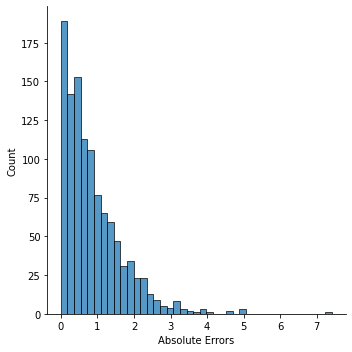

In [9]:
# Using model 3 because it had the lowest cross-validation error. Model 3 has already been trained on all the training data.

y_hat = model3.predict(Xtest)
errors = absolute_error(y_hat, ytest)
mae = mean_absolute_error(y_hat, ytest)
sns.displot(errors).set(xlabel="Absolute Errors")
interval_precision = 1.96*np.std(errors)/np.sqrt(len(errors))
print("Point estimate: {}, confidence interval:({},{})".format(mae, mae-interval_precision, mae+interval_precision))


'''Written answer: this is close to the cross validation error of the model I chose, but slightly less. This is because test error tends to underestimate the actual error. The values are close, however, because an independent validation/training set was used and both the validation and test sets were randomly selected samples from the data.'''

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.